# Principal component analysis of WHONDRS data

In [1]:
import pandas as pd
import numpy as np
from numpy.testing import assert_array_almost_equal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt

## Load data

In [2]:
# Load the features used to predict respiration rates:
predict_inputs = pd.read_csv('WH_RA_GL_global_predict_25_inputs.csv')

# Load the predicted respiration rates.  Store lon, lat, mean.error,
# and predict.error for later.
#predict_targets = pd.read_csv("../global_predict/GLORICH_global_predictions_v2.csv")
predict_targets = pd.read_csv("GLORICH_global_predictions_updated.csv")

# Check that the same number of sites are in both files
print('Shapes at start:')
print(predict_inputs.shape)
print(predict_targets.shape)

# Merge the two datasets now to cull missing data consistently across sites
predict_all = pd.concat([predict_inputs,predict_targets],axis=1)

# Check column transfer
print('Shape after concat:')
print(predict_all.shape)

# Check for NaN:
print(np.sum(np.isnan(predict_all)))

# Lots of missing values in oxygen, so drop all these.
predict_all.drop(columns=[
    'DO_mgL',
    'DOSAT'],
    inplace=True)

# 110 missing pH rows, drop whole rows.
predict_all.dropna(axis=0,how='any',inplace=True)

# Drop the respiration rates, but keep them later for plotting.
predict_rr = pd.DataFrame(
    predict_all.pop('rate.mg.per.L.per.h'),
    columns=pd.Index(['rate.mg.per.L.per.h']))

# Remove lon, lat, and errors and store for later
predict_xy = pd.DataFrame(predict_all.pop('lon'),columns=pd.Index(['lon']))
predict_xy['lat'] = predict_all.pop('lat')

predict_err = pd.DataFrame(predict_all.pop('mean.error'),columns=pd.Index(['mean.error']))
predict_err['predict.error'] = predict_all.pop('predict.error')

print('Shapes after NaN, x, y, error separation:')
print(predict_all.shape)
print(predict_xy.shape)
print(predict_err.shape)
print(predict_rr.shape)

predict_xy.reset_index(drop=True,inplace=True)
predict_err.reset_index(drop=True,inplace=True)
predict_rr.reset_index(drop=True,inplace=True)
predict_all.reset_index(drop=True,inplace=True)

# Load the respiration rates used for training.  This should be in
# exactly the same format as the merged predict_all but with fewer
# rows.  Remove oxygen and respiration rates.
#training_all = pd.read_csv("whondrml_global_train_25_inputs.csv")
training_all = pd.read_csv("whondrml_global_train_25_inputs_update.csv")
training_all.drop(columns=[
    'DO_mgL',
    'DOSAT',
    'rate.mg.per.L.per.h'],
    inplace=True)

print('Training data shape:')
print(training_all.shape)
#print(np.sum(np.isnan(training_all)))

# Concatenate the training and prediction data sets for input to PCA.
# Training data is at the head of the frame
# Collab data is at the tail of the frame
data_all = pd.concat([training_all,predict_all],axis=0)

print('data_all shape after adding training data:')
print(data_all.shape)
data_all.reset_index(drop=True,inplace=True)

# Remove any rows with any NaN in all columns execpt Gl_id
search_nan_cols = []
for col in data_all.columns:
    if col != 'GL_id':
        search_nan_cols.append(col)
        
data_all.dropna(
    axis=0,
    how='any',
    inplace=True,
    subset=search_nan_cols)

print('data_all shape after removing NaN:')
print(data_all.shape)
data_all.reset_index(drop=True,inplace=True)

# Check first lines of each data set
#print('====================Training data location is at top of dataframe=====================')
#print(data_all.iloc[0,:])
#print(training_all.iloc[0,:])

#print('====================Predict data location is at bottom of dataframe====================')
#print(data_all.iloc[179,:])
#print(predict_all.iloc[0,:])

Shapes at start:
(10529, 25)
(10529, 6)
Shape after concat:
(10529, 31)
RA_SO                     0
RA_dm                     0
run_mm_cyr                0
dor_pc_pva                0
gwt_cm_cav                0
ele_mt_cav                0
slp_dg_cav                0
sgr_dk_rav                0
tmp_dc_cyr                0
tmp_dc_cdi                0
pre_mm_cyr                0
pre_mm_cdi                0
for_pc_cse                0
crp_pc_cse                0
pst_pc_cse                0
ire_pc_cse                0
gla_pc_cse                0
prm_pc_cse                0
ppd_pk_cav                0
Temp_water                0
pH                       84
DO_mgL                 7534
DOSAT                  4797
RA_ms_av                  0
RA_ms_di                  0
GL_id                     0
lon                       0
lat                       0
rate.mg.per.L.per.h       0
mean.error                0
predict.error             0
dtype: int64
Shapes after NaN, x, y, error separation:
(1044

In [3]:
# Example for accessing the TRAINING DATA from the whole data set
data_all[np.isnan(data_all['GL_id'])]

,RA_SO,RA_dm,run_mm_cyr,dor_pc_pva,gwt_cm_cav,ele_mt_cav,slp_dg_cav,sgr_dk_rav,tmp_dc_cyr,tmp_dc_cdi,...,pst_pc_cse,ire_pc_cse,gla_pc_cse,prm_pc_cse,ppd_pk_cav,Temp_water,pH,RA_ms_av,RA_ms_di,GL_id
0,2.0,0.705442,187.0,0.0,49.0,743.0,46.0,16.0,87.0,203.0,...,1.0,1.0,0.0,0.0,2168.388,8.66,6.50,0.493269,1.186962,NaN
1,2.0,0.705442,187.0,0.0,49.0,743.0,46.0,16.0,87.0,203.0,...,1.0,1.0,0.0,0.0,2168.388,8.66,6.50,0.493269,1.186962,NaN
2,2.0,0.705442,187.0,0.0,49.0,743.0,46.0,16.0,87.0,203.0,...,1.0,1.0,0.0,0.0,2168.388,8.66,6.50,0.493269,1.186962,NaN
3,2.0,0.275159,429.0,0.0,134.0,97.0,26.0,38.0,127.0,243.0,...,0.0,3.0,0.0,0.0,146.491,19.95,6.50,0.602966,0.837069,NaN
4,2.0,0.275159,429.0,0.0,134.0,97.0,26.0,38.0,127.0,243.0,...,0.0,3.0,0.0,0.0,146.491,19.95,6.50,0.602966,0.837069,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,1.0,0.120339,457.0,0.0,15.0,9.0,6.0,0.0,147.0,220.0,...,0.0,10.0,0.0,0.0,25.496,22.90,6.50,0.064923,0.083367,NaN
265,4.0,0.932740,136.0,0.0,37.0,1354.0,3.0,22.0,89.0,272.0,...,3.0,51.0,0.0,0.0,299.058,16.90,8.49,0.348040,1.374016,NaN
266,2.0,0.215070,81.0,0.0,794.0,2441.0,130.0,335.0,20.0,233.0,...,16.0,0.0,0.0,0.0,0.000,10.34,8.31,0.203026,0.958993,NaN
267,5.0,2.621230,429.0,43.0,301.0,195.0,40.0,11.0,117.0,259.0,...,3.0,1.0,0.0,0.0,73.109,27.30,7.50,0.606730,1.662460,NaN


In [4]:
# Example for accessing the COLLAB DATA from the whole data set
data_all[data_all['GL_id'] < 10000]

,RA_SO,RA_dm,run_mm_cyr,dor_pc_pva,gwt_cm_cav,ele_mt_cav,slp_dg_cav,sgr_dk_rav,tmp_dc_cyr,tmp_dc_cdi,...,pst_pc_cse,ire_pc_cse,gla_pc_cse,prm_pc_cse,ppd_pk_cav,Temp_water,pH,RA_ms_av,RA_ms_di,GL_id
10706,3.0,0.671581,520.0,0.0,124.0,257.0,24.0,17.0,161.0,205.0,...,0.0,0.0,0.0,0.0,991.733,17.19,7.21,0.604679,1.138219,2.0
10707,2.0,0.354052,523.0,0.0,144.0,272.0,27.0,18.0,161.0,206.0,...,0.0,0.0,0.0,0.0,325.932,16.90,7.17,0.514822,0.978203,3.0
10708,1.0,0.157640,516.0,0.0,142.0,299.0,18.0,21.0,160.0,206.0,...,0.0,0.0,0.0,0.0,984.224,16.69,6.93,0.253176,0.483152,4.0
10709,2.0,0.544346,863.0,0.0,164.0,55.0,18.0,32.0,66.0,268.0,...,1.0,0.0,0.0,0.0,22.162,4.70,4.51,0.790864,0.658923,5.0
10710,4.0,1.615030,407.0,236.0,46.0,11.0,8.0,1.0,143.0,227.0,...,0.0,1.0,0.0,0.0,32.005,24.10,7.00,0.842995,1.278533,6.0
10711,3.0,0.497188,676.0,0.0,14.0,68.0,5.0,15.0,168.0,209.0,...,18.0,2.0,0.0,0.0,8.693,20.20,6.52,0.580649,1.061701,7.0
10712,6.0,3.123770,672.0,37.0,12.0,52.0,6.0,4.0,169.0,212.0,...,5.0,1.0,0.0,0.0,0.810,26.00,6.56,0.994333,1.781176,8.0
10713,4.0,1.232380,652.0,0.0,53.0,80.0,9.0,31.0,169.0,207.0,...,5.0,0.0,0.0,0.0,0.268,21.20,6.62,0.727854,1.368417,9.0


In [5]:
# Example for accessing the GLORICH DATA from the whole data set
data_all[data_all['GL_id'] > 10000]

,RA_SO,RA_dm,run_mm_cyr,dor_pc_pva,gwt_cm_cav,ele_mt_cav,slp_dg_cav,sgr_dk_rav,tmp_dc_cyr,tmp_dc_cdi,...,pst_pc_cse,ire_pc_cse,gla_pc_cse,prm_pc_cse,ppd_pk_cav,Temp_water,pH,RA_ms_av,RA_ms_di,GL_id
269,4.0,0.706055,41.0,1472.0,385.0,255.0,44.0,41.0,149.0,173.0,...,4.0,1.0,0.0,0.0,17.457,13.767403,8.020442,0.587159,1.150797,300043.0
270,5.0,1.161640,157.0,0.0,233.0,225.0,33.0,25.0,143.0,178.0,...,23.0,26.0,0.0,0.0,7.123,14.395833,8.145417,1.123422,0.888963,300086.0
271,4.0,0.812758,259.0,0.0,173.0,367.0,29.0,30.0,128.0,169.0,...,36.0,46.0,0.0,0.0,4.572,14.020747,7.960166,1.037157,0.788408,300022.0
272,3.0,0.558115,253.0,0.0,144.0,366.0,19.0,40.0,128.0,168.0,...,36.0,45.0,0.0,0.0,3.043,14.764315,8.135417,0.932445,0.730419,300023.0
273,4.0,0.428444,33.0,528.0,470.0,332.0,43.0,53.0,146.0,173.0,...,5.0,2.0,0.0,0.0,10.754,14.468224,8.086916,0.514126,1.049076,300153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10701,3.0,0.334463,58.0,5672.0,129.0,755.0,13.0,23.0,97.0,290.0,...,20.0,35.0,0.0,0.0,0.938,20.500000,8.210000,0.525861,0.880309,102011.0
10702,1.0,0.072905,59.0,0.0,50.0,758.0,7.0,9.0,96.0,287.0,...,27.0,65.0,0.0,0.0,1.649,25.130000,8.340000,0.173007,0.244597,104024.0
10703,3.0,0.298851,58.0,0.0,6.0,747.0,0.0,11.0,96.0,288.0,...,21.0,66.0,0.0,0.0,2.103,24.580000,7.960000,0.558138,0.785848,104020.0
10704,4.0,1.455140,414.0,17.0,10.0,479.0,4.0,24.0,83.0,190.0,...,10.0,1.0,0.0,0.0,672.255,10.037778,8.150282,1.173780,0.949299,301376.0


In [6]:
# We do not want the ID to be part of the PCA, 
# so pull it out now and concatenate it later as needed.
id_df = pd.DataFrame(data_all.pop('GL_id'),columns=pd.Index(['GL_id']))

## Scale the data
 The data are now loaded in "real" units but we need to first scale them.  The StandardScaler will subtract the mean of the data and divide by the standard deviation.  This normalization is done **columnwise** (i.e. for each feature) which means that variables that have very different magnitudes (i.e. units) and variabilities will become more comparable after the normalization.

Text(0, 0.5, 'Site')

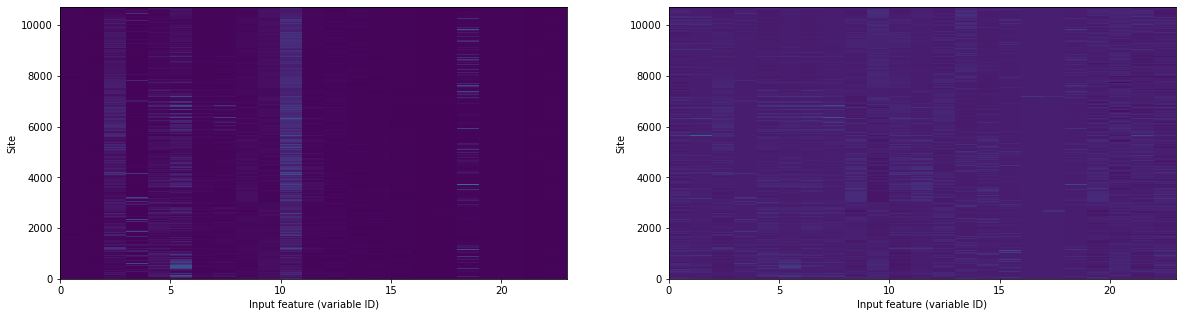

In [7]:
# cnsd = center, normalize by standard deviation
cnsd = StandardScaler()
cnsd.fit(data_all)
data_all_scaled = cnsd.transform(data_all)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.pcolor(data_all)
ax0.set_xlabel('Input feature (variable ID)')
ax0.set_ylabel('Site')

ax1.pcolor(data_all_scaled)
ax1.set_xlabel('Input feature (variable ID)')
ax1.set_ylabel('Site')

Above is a raw data plot of the original (left) and scaled (right) data.  In the original data, certain variables are very "strong" while others are "washed out".  In the scaled data, the variability is distributed more evenly across the dataset.

Text(0, 0.5, 'Magnitude in normalized units (non-dimensional)')

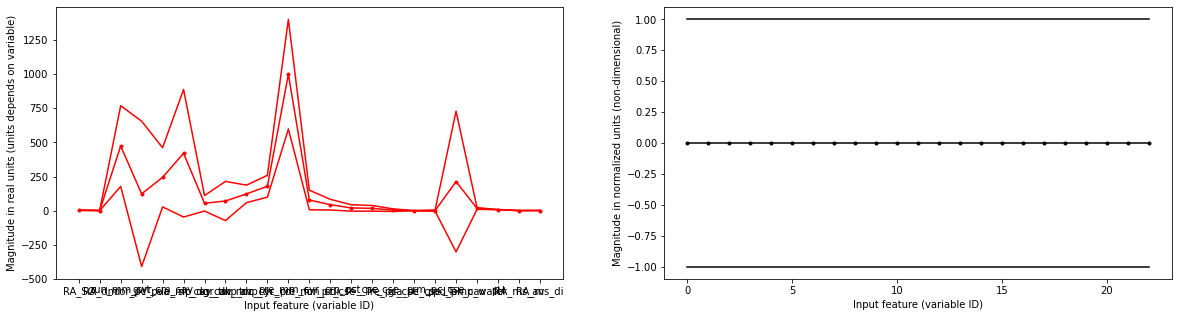

In [8]:
# Another way to see this is to plot the mean and std envelope of the data.
# It's not fair to compare variables with dramatically different ranges.
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(data_all.mean(0)+data_all.std(0),'r')
ax0.plot(data_all.mean(0)-data_all.std(0),'r')
ax0.plot(data_all.mean(0),'r.-')
ax0.set_xlabel('Input feature (variable ID)')
ax0.set_ylabel('Magnitude in real units (units depends on variable)')

ax1.plot(data_all_scaled.mean(0)+data_all_scaled.std(0),'k-')
ax1.plot(data_all_scaled.mean(0)-data_all_scaled.std(0),'k-')
ax1.plot(data_all_scaled.mean(0),'k.-')
ax1.set_xlabel('Input feature (variable ID)')
ax1.set_ylabel('Magnitude in normalized units (non-dimensional)')

The plot above is simply the columnwise mean of the panels in the previous plot to highlight the different magnitudes and variabilities of the unscaled data and how those magnitudes and variabilities are uniform in the scaled data.

In [9]:
# Can you recover the data from the scaler?  Yes!
assert_array_almost_equal(data_all, cnsd.inverse_transform(data_all_scaled),decimal=6)

# So overwrite the data to a scaled version
data_all = data_all_scaled

## Run the PCA

Please see [eickenberg's post](https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn) for a documented example of the steps associated with PCA in the [scikit-learn framework](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  The terminology for PCA/EOF is **not** standardized but I find [this post by Erik Kaplan to be a good starting point for the theory](https://websites.pmc.ucsc.edu/~dmk/notes/EOFs/EOFs.html).

Here, I will use the terminology in [Hakkinen and Rhines (2004)](https://www.science.org/doi/abs/10.1126/science.1094917) since I like the visual maps-time series decomposition approach. Features (columns in the data) are the spatial dimension and samples (rows in the data) are the temporal dimension.  An EOF is a spatial pattern (a *representative* row across the data table) and a PC is a temporal pattern (a *representative* column across the data).

(For our purposes here, since the sites are assumed to be independent of each other, we are not interested in PC's or representative columns.  Rather, we want to find which sites are closest/furthest from the most representative rows in the data.)

In the scikit-learn framework, a "component" (`pca.components_`) is the same as an "EOF spatial pattern" since a component is made up of a list of normalized "strengths" of each feature for that component.

James' suggestion for our approach:

1. Do a single PCA that has all the original sampling locations and all the potential sampling locations. The PCA would be based on all the variables being used to predict respiration rate. Or maybe we should include only the top ~10 variables (based on their explanatory importance)?
2. Across the first two PCA axes, find the centroid for only the original sampling locations
3. For each potential sampling locations calculate the distance to the original locations centroid. This is a measure of how environmentally different a potential site is from the original sites. Community guidance is to maximize this distance…but to also…
4. …consider model uncertainty. To bring this in, find the model uncertainty for each potential sampling site.
5. Normalize distance-to-centroid and the model uncertainty values by dividing each by their max value so that each is restricted to vary between 0 and 1. This way they are on the same scale and all are positive (let’s make sure that all are positive values). This makes the assumption that we value distance-to-centroid as much as we value model uncertainty in terms of their influence over our site selection.
6. Then multiply the normalized distance-to-centroid by the normalized model uncertainty for each potential sampling site. Larger distance-to-centroid and larger uncertainty values both lead to higher priority sites. As such, sites with the highest products are the highest priority for sampling.
7. Then make a map based on the products. This shows the spatial distribution of site priorities.
8. Make a second map showing the 20 sites with the highest products (i.e., priority values). The reason for 20 sites is that we’d like to start by initially reaching out folks near 15 sites. Having the top 20 would allow us to down-select based on logistical constraints (e.g., distance to university, etc.).

In [10]:
# Fit the PCA. Data are automatically centered (no
# need to subtract the mean).
pca = PCA()
pca.fit(data_all)

# Compare to traditional linear algebra (not perfect, but close enough
# given unconstrained differences in solving approach, etc.)
#U, S, VT = np.linalg.svd(data_all - data_all.mean(0))
#assert_array_almost_equal(VT, pca.components_,decimal=2)

PCA()

In [11]:
# Find the loadings for each sample = how much of each component contributes to that sample.
# [n_samples, n_features] dot TRANSPOSE([n_components, n_features]) = [n_samples, n_components]
data_all_pca = pca.transform(data_all)

# Compate to traditional linear algebra
# pca.components_ = ndarray of shape (n_components, n_features) 
data_all_pca2 = (data_all - pca.mean_).dot(pca.components_.T)
assert_array_almost_equal(data_all_pca, data_all_pca2)

In [12]:
# Reconstruct data back in original space
data_projected = pca.inverse_transform(data_all_pca)

# Compare to traditional linear algebra
data_projected2 = data_all_pca.dot(pca.components_) + pca.mean_
assert_array_almost_equal(data_projected, data_projected2)

In [13]:
# Check to what extent we recover our data
loss = np.sum((data_all - data_projected) ** 2, axis=1).mean()
print(loss)

3.256028627031467e-29


## Plot PCA output
The following plots show critical aspects of the PCA results and also perform a sanity check.

1.0


Text(0, 0.5, 'Percent of variance explained')

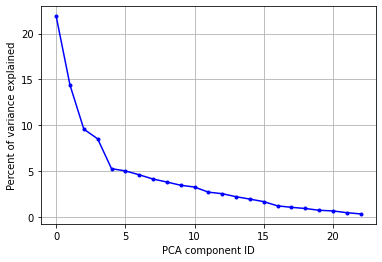

In [14]:
# Plot the variance of each component to get a feel which components to keep
fig, ax = plt.subplots()
ax.plot(100*pca.explained_variance_ratio_,'b.-')
ax.grid()
print(np.sum(pca.explained_variance_ratio_))
ax.set_xlabel('PCA component ID')
ax.set_ylabel('Percent of variance explained')

The first 4 components contain the bulk of the variance.

Text(0.5, 0, 'Site feature index (variable ID)')

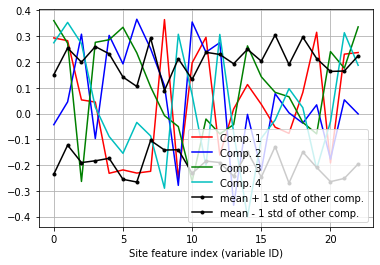

In [15]:
#Plot the first 4 components' spectra and compare the to the mean and variance of the remaining components.
fig, ax = plt.subplots()
ax.plot(pca.components_[0,:],'r')
ax.plot(pca.components_[1,:],'b')
ax.plot(pca.components_[2,:],'g')
ax.plot(pca.components_[3,:],'c')

ax.plot(pca.components_[4:-1,:].mean(0) + pca.components_[4:-1,:].std(0),'k.-')
ax.plot(pca.components_[4:-1,:].mean(0) - pca.components_[4:-1,:].std(0),'k.-')
ax.grid()

ax.legend(['Comp. 1','Comp. 2','Comp. 3','Comp. 4','mean + 1 std of other comp.','mean - 1 std of other comp.'])
ax.set_xlabel('Site feature index (variable ID)')

**With UNSCALED data,** there are nice inverse patterns between the peaks in the most important components and the rest of the data.  In particular, features (starting to count with 0!) 2, 3, 5, 6, 10, and 18 seem to be the most important features for the most significant components.  These are the annual mean runoff and precipitation (2 and 10), degree of regulation (3), the elevation and slope (5 and 6), and the population density.  This pattern holds whether or not respiration rate is included.

**However, with SCALED data.,** the patterns a more complicated and reflect the fact that with the unscaled data, the variables that appeared most important were actually the ones with the biggest magnitudes.  The patterns are much more complicated in this case.

Text(0, 0.5, 'Magnitude in PCA space')

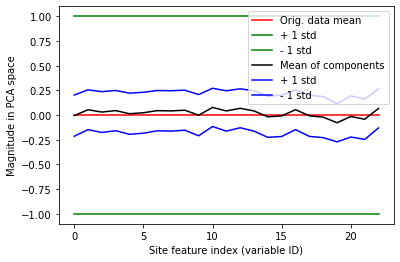

In [16]:
# Test converting the components into real space.
components_in_real_space = pca.inverse_transform(pca.components_)

fig, ax = plt.subplots()
#for i in range(0,100):
#    ax.plot(data_all.iloc[i,:],'r')
#for i in range(0,23):
#    ax.plot(components_in_real_space[i,:],'k')
ax.plot(data_all.mean(0),'r')
ax.plot(data_all.mean(0)+data_all.std(0),'g')
ax.plot(data_all.mean(0)-data_all.std(0),'g')

ax.plot(components_in_real_space.mean(0),'k')
ax.plot(components_in_real_space.mean(0)+components_in_real_space.std(0),'b')
ax.plot(components_in_real_space.mean(0)-components_in_real_space.std(0),'b')

ax.legend(['Orig. data mean','+ 1 std','- 1 std','Mean of components','+ 1 std','- 1 std'])
ax.set_xlabel('Site feature index (variable ID)')
ax.set_ylabel('Magnitude in PCA space')

The plot above shows that the variance of the input data is uniformly 1 and the variance of the compnents (which are basically filtered) is much smaller.  These data are all normalized!  To get them in "real" units, we must de-normalize (i.e. multiply by the standard deviation and add the mean).

Text(0, 0.5, 'Magnitude in real data space')

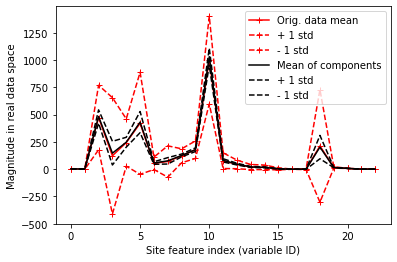

In [17]:
# Let's also de-normalize everything to compare to
# check in "real" units
fig, ax = plt.subplots()
orig_data_all = cnsd.inverse_transform(data_all)
comp_xformed = cnsd.inverse_transform(components_in_real_space)

ax.plot(orig_data_all.mean(0),'r-+')
ax.plot(orig_data_all.mean(0)+orig_data_all.std(0),'r--+')
ax.plot(orig_data_all.mean(0)-orig_data_all.std(0),'r--+')

ax.plot(comp_xformed.mean(0),'k')
ax.plot(comp_xformed.mean(0)+comp_xformed.std(0),'k--')
ax.plot(comp_xformed.mean(0)-comp_xformed.std(0),'k--')

ax.legend(['Orig. data mean','+ 1 std','- 1 std','Mean of components','+ 1 std','- 1 std'])
ax.set_xlabel('Site feature index (variable ID)')
ax.set_ylabel('Magnitude in real data space')

The plot above compares the variance of the original, unnormalized data to the variance of the components (also de-normalized) - all in real units.  This is consistent with expectations; the components are basically a filtered version of the original data.

## Find the most different and most similar sites.
We have basically already done this!  In the cell that computes the loadings, we executed:
```python
# Find the loadings for each sample = how much of each component contributes to that sample.
# [n_samples, n_features] dot TRANSPOSE([n_components, n_features]) = [n_samples, n_components]
data_all_pca = pca.transform(data_all)

# Compate to traditional linear algebra
# pca.components_ = ndarray of shape (n_components, n_features) 
data_all_pca2 = (data_all - pca.mean_).dot(pca.components_.T)
```

(Note that the second block is simply repeating the first, but it's showing explicitly what is happening with the linear algebra for reference.)  This code means that data_all_pca has a row for each site and along that row is a number that represents the relative weight of each component to that site.

Sum over all component contributions: 9.094947017729282e-13


Text(0, 0.5, 'Net proximity to all components for a given site')

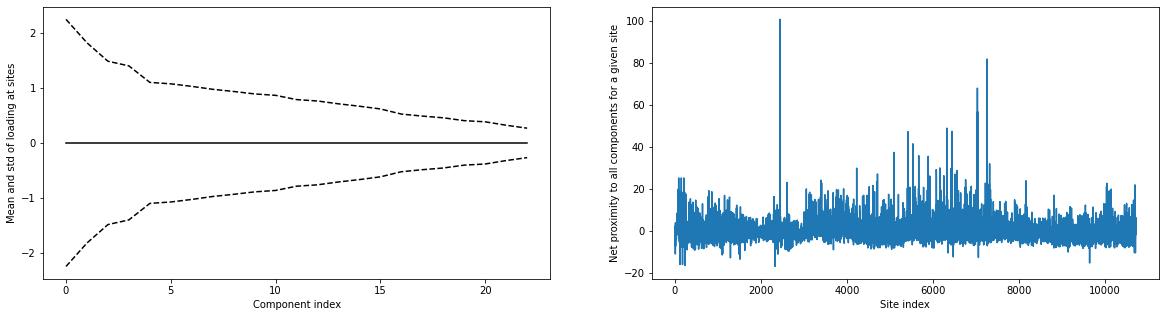

In [18]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(data_all_pca.mean(0),'k')
ax0.plot(data_all_pca.mean(0)+data_all_pca.std(0),'k--')
ax0.plot(data_all_pca.mean(0)-data_all_pca.std(0),'k--')
ax0.set_xlabel('Component index')
ax0.set_ylabel('Mean and std of loading at sites')

# Note that for each site if you add up all the
# contributions of the components over all sites, you get 0.
print('Sum over all component contributions: '+str(np.sum(np.sum(data_all_pca,axis=1))))

# But each site definitely has a different net proximity to
# the components...
ax1.plot(np.sum(data_all_pca,axis=1))
ax1.set_xlabel('Site index')
ax1.set_ylabel('Net proximity to all components for a given site')

The plot above shows that the actual magnitude of which component contributes to which site is pretty uniform while the variability is biggest for the components on the left (those with the largest power or contribution to the variance of the data) while the components on the right (which have less explanatory power) don't have as much variability.  This result is consistent with the idea that we want to find the sites that are most (and least) different from the components with the most explanatory power -> some sites are really different!

James suggested that we look at the first two components which is consistent with the plot of explained variance wrt component; the first two components are far and away the most important.  However, we can also be more general and weight the distance between each component by the ratio of explained variance - we use the distance from all components and add them up, but those distances are weighted by the amount each component actually contributes to the whole.

In [19]:
# Merge the GL_id back into the PCA'ed data for indexing
# All training data (WHONDRS) - GL_id = NaN
# All collab data - GL_id < 100000
data_all_pca_w_id = pd.concat([id_df,pd.DataFrame(data_all_pca)],axis=1)

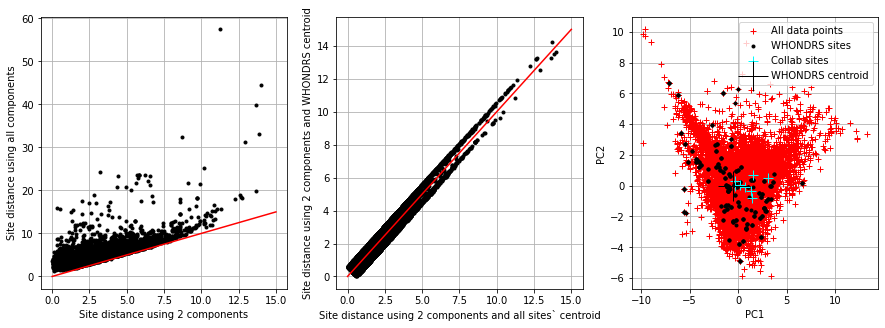

In [20]:
# (The next two cases are by default wrt centroid of all data
# because data_all_pca.mean(0) ~ zeros.  If we are using
# the loadings - 0 = loadings, then we are implicitly
# subtracting zero, the centroid of all the data.)
#print(np.mean(data_all_pca.mean(0)))
#print(np.std(data_all_pca.mean(0)))

# Using just the first two components:
pca_n2_dist = np.linalg.norm(data_all_pca[:,0:2],axis=1)
#print(np.min(pca_n2_dist))

# Using all components weighted by explanatory power
# (THIS IS NOT STRICTLY DISTANCE!!!)
#pca_all_dist = np.abs(data_all_pca.dot(pca.explained_variance_ratio_))

# Using all components (unweighted)
pca_all_dist = np.linalg.norm(data_all_pca,axis=1)
#print(np.min(pca_all_dist))

# Plots below show that first two components are similar
# to using all components. Stick with just two components.
# James' suggestion for using the first two components
# and the difference between the centroid of the WHONDRS sites:
# 1) Get the WHONDRS PCA data and get collab PCA data
# (square brackets at the end trim off the ID column while
# retaining the PCA component data).  Collab PCA data is only
# separated for visualization purposes, not used in final calcs.
data_WHONDRS_pca = data_all_pca_w_id[np.isnan(data_all_pca_w_id['GL_id'])].values[:,1:]
data_collab_pca = data_all_pca_w_id[data_all_pca_w_id['GL_id'] < 10000].values[:,1:]

# 2) Get the WHONDRS centroid:
WHONDRS_centroid = data_WHONDRS_pca.mean(0)

# Old version with orig data hard coded!
#WHONDRS_centroid = data_all_pca[0:179].mean(0)

# 3) Get the distance wrt WHONDRS centroid using 
#    only first two PCA components:
pca_n2_WHONDRS_dist = np.linalg.norm(
    (data_all_pca[:,0:2] - WHONDRS_centroid[0:2]),axis=1)
#print(np.min(pca_n2_WHONDRS_dist))

# 4) Plots
# Compare all components to 2 components
fig, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(15,5))
ax0.plot(pca_n2_dist,pca_all_dist,'k.')
ax0.set_xlabel('Site distance using 2 components')
ax0.set_ylabel('Site distance using all components')
ax0.plot([0,15],[0,15],'r-')
ax0.grid()

# Compare all-data centroid to WHONDRS centroid
ax1.plot(pca_n2_dist,pca_n2_WHONDRS_dist,'k.')
ax1.set_xlabel('Site distance using 2 components and all sites` centroid')
ax1.set_ylabel('Site distance using 2 components and WHONDRS centroid')
ax1.plot([0,15],[0,15],'r-')
ax1.grid()

# Plot PC1 v.s. PC2
ax2.plot(data_all_pca[:,0],data_all_pca[:,1],'r+')
ax2.plot(data_WHONDRS_pca[:,0],data_WHONDRS_pca[:,1],'k.')
ax2.plot(data_collab_pca[:,0],data_collab_pca[:,1],'c+',markerfacecolor="none", markersize="10", markeredgecolor="cyan")
# Hard coded data limits
#ax2.plot(data_all_pca[0:179,0],data_all_pca[0:179,1],'k.')

# Do NOT need to plot all data centroid - it is zero by definition
ax2.plot(WHONDRS_centroid[0],WHONDRS_centroid[1],'k+',markerfacecolor="none", markersize="30", markeredgecolor="black")
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.grid()
ax2.legend(['All data points','WHONDRS sites','Collab sites','WHONDRS centroid'])

**Left:** There is a correspondence between using just the first two components and using all the components.  Let's use the first two components since that will most likely be easiest to explain during the community meeting.

**Center:** There is a pretty good relationship (albiet noise and systematic offsets) between using the centroid of all sites and the centroid of just the WHONDRS sites.

**Right:** Plot showing the strength of the first two components for each site.  The black dots are the WHONDRS sites, the red + are the sites where predictions are made, and the large black + is the centroid of the WHONDRS sites.

Finally, we need to:
1. merge these PCA distance results with the errors,
2. normalize PCA distance and error, 
4. combine them, and 
5. rank the sites.

In [21]:
# Get just the IDs for the predict points (GLORICH + COLLAB)
id_predict_df = id_df[np.logical_not(np.isnan(id_df['GL_id']))]

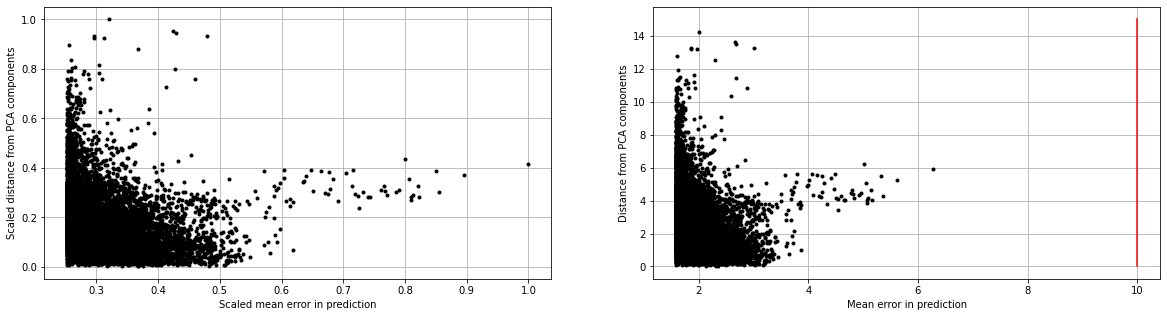

In [22]:
# Concatenate the PCA distance with the errors
predict_err['pca.dist'] = pd.DataFrame(
    pca_n2_WHONDRS_dist[
        np.logical_not(
            np.isnan(data_all_pca_w_id['GL_id']))])

# Normalize and combine PCA distance with error
predict_err['mean.error.scaled'] = predict_err['mean.error']/predict_err.max()['mean.error']
predict_err['pca.dist.scaled'] = predict_err['pca.dist']/predict_err.max()['pca.dist']
predict_err['combined.metric'] = predict_err['mean.error.scaled']*predict_err['pca.dist.scaled']

# Ensure all dataframe indeces are restarted
id_predict_df.reset_index(drop=True,inplace=True)
predict_err.reset_index(drop=True,inplace=True)
predict_rr.reset_index(drop=True,inplace=True)
predict_xy.reset_index(drop=True,inplace=True)

# Put all output into a single dataframe
output_df = pd.concat([
    id_predict_df,
    predict_xy,
    predict_rr,
    predict_err],axis=1)

# Sanity plots
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(predict_err['mean.error.scaled'],predict_err['pca.dist.scaled'],'k.')
ax0.set_xlabel('Scaled mean error in prediction')
ax0.set_ylabel('Scaled distance from PCA components')
ax0.grid()

ax1.plot(output_df['mean.error'],output_df['pca.dist'],'k.')
ax1.set_xlabel('Mean error in prediction')
ax1.set_ylabel('Distance from PCA components')
ax1.plot([10,10],[0,15],'r')
ax1.grid()

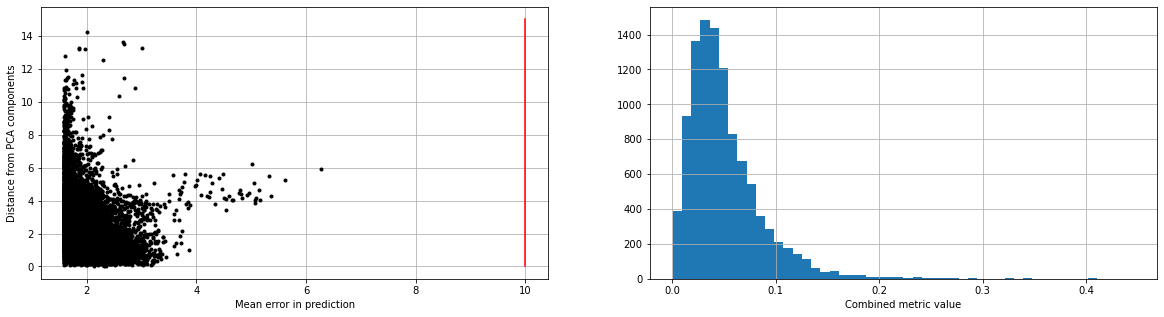

In [23]:
if 1 == 0:
    # Deactivate clipping
    
    # Clip the errors outliers (vals more than 3.5 in SCALED space, but more than 10 in UNSCALED!).
    output_df.loc[(output_df['mean.error'] > 10)]=np.nan
    output_df.dropna(axis=0,how='any',inplace=True)

# Plots to check clipping and final distribution of data
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(output_df['mean.error'],output_df['pca.dist'],'k.')
ax0.set_xlabel('Mean error in prediction')
ax0.set_ylabel('Distance from PCA components')
ax0.plot([10,10],[0,15],'r')
ax0.grid()

h = ax1.hist(output_df['combined.metric'],50)
ax1.grid()
ax1.set_xlabel('Combined metric value')

# Sort based on the combined metric
output_sorted_df = output_df.sort_values(by='combined.metric',axis=0)

# Write to output files
output_sorted_df.to_csv('predicted_sites_ranking_updated.csv',index=False)
output_df.to_csv('predicted_sites_updated.csv',index=False)

# Repeat this analysis with a PCA driven entirely by the observed sites. --- THIS HAS NOT BEEN UPDATED!!!
Sanity checks here are more limited since we have already checked the pipeline above.

The reason for doing this is that the PCA with all the data contains far more sites from GLORICH than from WHONDRS so the patterns that are identified are potentially very different from patterns in the WHONDRS data alone.  As can be seen below, there is a broad correspondence between the distance metrics for the two different fits, so either one is fine. 

In [ ]:
# Use whole dataset that is already scaled so we don't have issues of different centering.
training_scaled = data_all[0:179,:]
print(training_scaled.shape)

# Put here to test offset that can be created by WHONDRS having a lower average stream order than GLORICH
#training_scaled[:,0] += 10

# Old data set
#predict_scaled = data_all[179:13015]
# Update data set
predict_scaled = data_all[383:11099]
print(predict_scaled.shape)

# Fit the PCA. Data are automatically centered.
pca_obs = PCA()
pca_obs.fit(training_scaled)

# Plot the variance of each component to get a feel which components to keep
fig, ax = plt.subplots()
ax.plot(pca_obs.explained_variance_ratio_,'b.-')
ax.grid()
print(np.sum(pca.explained_variance_ratio_))

In [ ]:
# Find the loadings for each sample = how much of each component contributes to that sample.
# [n_samples, n_features] dot TRANSPOSE([n_components, n_features]) = [n_samples, n_components]
predict_pca = pca_obs.transform(predict_scaled)

In [ ]:
# Assess the loadings
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(predict_pca.mean(0),'r--')
ax0.plot(predict_pca.mean(0)+predict_pca.std(0),'r')
ax0.plot(predict_pca.mean(0)-predict_pca.std(0),'r')

ax0.plot(data_all_pca.mean(0),'k--')
ax0.plot(data_all_pca.mean(0)+data_all_pca.std(0),'k')
ax0.plot(data_all_pca.mean(0)-data_all_pca.std(0),'k')
ax0.set_xlabel('Component index')
ax0.set_ylabel('Mean and std of loading at sites')

# Note that for each site if you add up all the
# contributions of the components over all sites, you get 0.
print('Sum over all component contributions: '+str(np.sum(np.sum(predict_pca,axis=1))))

# But each site definitely has a different net proximity to
# the components...
ax1.plot(np.sum(predict_pca,axis=1),'r')
ax1.plot(np.sum(data_all_pca,axis=1),'k')
ax1.set_xlabel('Site index')
ax1.set_ylabel('Net proximity to all components for a given site')

The observation-only and all-data PCA's have similar loading spectra and similar amplitudes of distance metrics.

In [ ]:
# Compute the distance metric using the first two components:
pca_obs_n2_dist = np.linalg.norm(predict_pca[:,0:2],axis=1)
print(pca_obs_n2_dist.shape)

# Grab the errors
err_dist_df = pd.DataFrame(predict_err['mean.error'],columns=pd.Index(['mean.error']))

# Grab the distances
err_dist_df['pca.dist'] = pca_obs_n2_dist

# Standardize the two metrics (error and distance)
metric_scaler = MaxAbsScaler()
metric_scaler.fit(err_dist_df)
err_dist_scaled = metric_scaler.transform(err_dist_df)

# Combine the two metrics by multiplication
combined_metric = err_dist_scaled[:,0]*err_dist_scaled[:,1]

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(err_dist_scaled[:,0],err_dist_scaled[:,1],'k.')
ax0.set_xlabel('Scaled mean error in prediction')
ax0.set_ylabel('Scaled distance from PCA components')
ax0.grid()

# Copy lon, lat, respration rate, errors, PCA distances,
# and the combined metric into a single dataframe for 
# writing to csv. ABS VALUE OF COMBINED METRIC HERE!!!
tmp_df = pd.DataFrame(np.abs(combined_metric),columns=pd.Index(['combined.metric']))
output_df = pd.concat([predict_xy,predict_rr,err_dist_df,tmp_df],axis=1)

ax1.plot(output_df['mean.error'],output_df['pca.dist'],'k.')
ax1.set_xlabel('Mean error in prediction')
ax1.set_ylabel('Distance from PCA components')
ax1.plot([10,10],[0,15],'r')
ax1.grid()

In [ ]:
# Clip the errors outliers
output_df.loc[(output_df['mean.error'] > 10)]=np.nan
output_df.dropna(axis=0,how='any',inplace=True)

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(output_df['mean.error'],output_df['pca.dist'],'k.')
ax0.set_xlabel('Mean error in prediction')
ax0.set_ylabel('Distance from PCA components')
ax0.plot([10,10],[0,15],'r')
ax0.grid()

h = ax1.hist(output_df['combined.metric'],50)
ax1.grid()
ax1.set_xlabel('Combined metric value')

# Sort based on the combined metric
output_sorted_df = output_df.sort_values(by='combined.metric',axis=0)

# Write values to file
output_sorted_df.to_csv('predicted_sites_ranking_WHONDRS_only_fit_updated.csv')

# Compare the all-data and WHONDRS-only PCA results

In [ ]:
# Load data
dat = pd.read_csv('predicted_sites_ranking.csv')
who = pd.read_csv('predicted_sites_ranking_WHONDRS_only_fit.csv')

# Sort by index so we can compare 1-1 (i.e. undo sorting by combined.metric)
dat.sort_values(by='Unnamed: 0',inplace=True)
who.sort_values(by='Unnamed: 0',inplace=True)

# Compare!
fig, ax0 = plt.subplots()
ax0.plot(dat['pca.dist'],who['pca.dist'],'r.')
ax0.plot(100*dat['combined.metric'],100*who['combined.metric'],'k.')
ax0.plot(dat['mean.error'],who['mean.error'],'g.')
ax0.grid()
ax0.set_xlabel('All data metric')
ax0.set_ylabel('WHONDRS-only PCA fit metric')
ax0.legend(['PCA dist','Combined metric (x100)','Mean error'])

The magnitude of the distance metric from the PCA fit with all the data is broadly consistent with the magnitude of the distance metric from the PCA fit with ONLY the WHONDRS data.

# Really simple PCA for reference
This is an opportunity to verify PCA terminology/concepts in the scikit-learn framework. This an attempt to recreate the simple 2D example by [Powell and Lehe](https://setosa.io/ev/principal-component-analysis/).

In [ ]:
# Make a small dataset with a strong linear correlation
x = np.arange(1,100)
x = np.expand_dims(x,axis=0)
y = x + np.random.randn(99)

fig, ax = plt.subplots()
ax.plot(x,y,'k.')
ax.grid()

In [ ]:
# Preprocess data and run PCA
data = np.concatenate((x,y),axis=0)
print(np.shape(data))

# Need to make samples in rows, features in columns
data = data.T
print(np.shape(data))

tiny_pca = PCA()
tiny_pca.fit(data)
loadings = tiny_pca.transform(data)
print(np.shape(loadings))
print(np.shape(tiny_pca.components_))

In [ ]:
#pca.components_ = [n_components, n_features]
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(100*tiny_pca.explained_variance_ratio_,'k.-')
ax0.grid()
ax0.set_xlabel('Component ID')
ax0.set_ylabel('Percent variance explained')

ax1.plot(loadings[:,0],loadings[:,1],'k.')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.grid()

**LEFT:** In the left plot, we see that PC1 retains most of the variability of the data.
**RIGHT:** In the right plot above, the range of the data (centered) is largest along PC1 and smallest along PC2.

## Repeat the simple test with two lines with two different slopes.
When plotting the loadings, the points from the two different lines occupy different spaces in the PC1 v.s. PC2 plot (red dots versus black dots).  The loadings are the "strength" of each component for each sample.

In [ ]:
z = 2*x + np.random.randn(99)
data = np.concatenate(
    (np.concatenate((x,y),axis=0),
     np.concatenate((x,z),axis=0)),
    axis=1)
data = data.T
print(np.shape(data))

fig, ax = plt.subplots()
ax.plot(data[0:99,0],data[0:99,1],'k.')
ax.plot(data[100:199,0],data[100:199,1],'r.')
ax.grid()

In [ ]:
tiny_pca = PCA()
tiny_pca.fit(data)
loadings = tiny_pca.transform(data)
print(np.shape(loadings))
print(np.shape(tiny_pca.components_))

In [ ]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(100*tiny_pca.explained_variance_ratio_,'k.-')
ax0.grid()
ax0.set_xlabel('Component ID')
ax0.set_ylabel('Percent variance explained')

ax1.plot(loadings[0:99,0],loadings[0:99,1],'ko')
ax1.plot(loadings[100:199,0],loadings[100:199,1],'ro')

# Define two centroids based on the two different lines
centroid1 = loadings[0:99].mean(0)
centroid2 = loadings[100:199].mean(0)

ax1.plot(centroid1[0],centroid1[1],'k+',ms=100)
ax1.plot(centroid2[0],centroid2[1],'r+',ms=100)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.grid()

In [ ]:
# Finally, compute the distance between each point and each centroid
diff_to_c1 = loadings - centroid1
diff_to_c2 = loadings - centroid2
dist_to_c1 = np.linalg.norm(diff_to_c1,axis=1)
dist_to_c2 = np.linalg.norm(diff_to_c2,axis=1)

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(20,5))
ax0.plot(diff_to_c1[0:99,0],diff_to_c1[0:99,1],'k.')
ax0.plot(diff_to_c2[0:99,0],diff_to_c2[0:99,1],'k+')
ax0.plot(diff_to_c1[100:199,0],diff_to_c1[100:199,1],'r.')
ax0.plot(diff_to_c2[100:199,0],diff_to_c2[100:199,1],'r+')
ax0.grid()

ax1.plot(dist_to_c1,'k.')
ax1.plot(dist_to_c2,'r.')

**RIGHT:** The black line is the distance between each point and the first centroid and the red line is the distance between each point and the second centroid.  In the PC1 vs PC2 plot above, the first centroid is the black + and the second centroid is the red +.  